# Предсказываем, будет ли рекомедовать товар в своём отзыве покупатель
На данных ритейлера женской одежды

In [1]:
import pandas
import sklearn.preprocessing as preprocess
import sklearn.model_selection as model_selection
import sklearn.neighbors as knn
import sklearn.metrics as metrics
import sklearn.pipeline as pipeline
import sklearn.ensemble as ens
import sklearn.tree as tree
import pylab as plt

def scores(y, predicted):
    print("F - мера {0}".format(metrics.f1_score(y, predicted)))
    print("Полнота {0}".format(metrics.recall_score(y, predicted)))
    print("Точность {0}".format(metrics.precision_score(y, predicted)))
    print("Доля верных ответов {0}".format(metrics.accuracy_score(y, predicted)))

### Предобработка данных

In [2]:
dataset = pandas.read_csv('e-com.csv', sep=',')
dataset = dataset.drop(columns=['Title', 'Review Text', 'Unnamed: 0', 'Positive Feedback Count', 'Rating'])
df = pandas.get_dummies(dataset, prefix=['Division Name', 'Department Name', 'Class Name', 'Recall'], drop_first=True)
scaler = preprocess.StandardScaler()
scaler.fit_transform(df[['Clothing ID', 'Age']])
df[['Clothing ID', 'Age']] = scaler.transform(
    df[['Clothing ID', 'Age']])
print(df.head())

ValueError: Length of 'prefix' (4) did not match the length of the columns being encoded (3).

In [4]:
y = df['Recommended IND']
X = df.drop(columns=['Recommended IND'])

### Классификатор KNN

In [5]:
clf = knn.KNeighborsClassifier(n_neighbors=10)
X_train, X_holdout, y_train, y_holdout = model_selection.train_test_split(
    X, y, test_size = 0.3, random_state = 17)
clf.fit(X_train,y_train)
scores(y_holdout,clf.predict(X_holdout))

F - мера 0.894438317315267
Полнота 0.9789618899810312
Точность 0.8233502538071066
Доля верных ответов 0.8098211751348283


#### Использование Pipeline

In [6]:
knn_pipe = pipeline.Pipeline([('scaler',preprocess.StandardScaler()),
                              ('knn',knn.KNeighborsClassifier(n_jobs=-1))])
knn_pipe.fit(X_train,y_train)
scores(y_holdout,knn_pipe.predict(X_holdout))

F - мера 0.8883761635770546
Полнота 0.9627521986549405
Точность 0.8246676514032496
Доля верных ответов 0.8008799318762418


#### Поиск гиперпараметров

In [7]:
knn_params = {
        'n_neighbors': range(1, 20)
}
knn_grid = model_selection.GridSearchCV(
        knn.KNeighborsClassifier(), knn_params, cv=5, n_jobs=-1, verbose=True)
knn_grid.fit(X_train, y_train)

Fitting 5 folds for each of 19 candidates, totalling 95 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   21.1s
[Parallel(n_jobs=-1)]: Done  95 out of  95 | elapsed:   46.5s finished


GridSearchCV(cv=5, error_score='raise',
       estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform'),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'n_neighbors': range(1, 20)}, pre_dispatch='2*n_jobs',
       refit=True, return_train_score='warn', scoring=None, verbose=True)

In [8]:
knn_grid.best_params_

{'n_neighbors': 19}

In [9]:
knn_grid.best_score_

0.8217153284671533

In [10]:
etalon_knn = knn.KNeighborsClassifier(n_neighbors=knn_grid.best_params_['n_neighbors'])
etalon_knn.fit(X_train,y_train)
scores(y_holdout,etalon_knn.predict(X_holdout))

F - мера 0.9026479750778816
Полнота 0.9993102259010174
Точность 0.8230365004970884
Доля верных ответов 0.8225943797899518


### Построение решающего дерева

In [11]:
tree_clr = tree.DecisionTreeClassifier(max_depth = 7, random_state = 100)
tree_clr.fit(X_train, y_train)
scores(y_holdout, tree_clr.predict(X_holdout))

F - мера 0.9003361213163449
Полнота 0.9931022590101741
Точность 0.8234200743494424
Доля верных ответов 0.8190462673857508


#### Поиск гиперпараметров

In [12]:
tree_params = {
        'max_depth': range(1, 10),
        'max_features': range(1, 28),
}
tree_grid = model_selection.GridSearchCV(
        tree.DecisionTreeClassifier(), tree_params, cv=5, n_jobs=-1, verbose=True)
tree_grid.fit(X_train, y_train)

Fitting 5 folds for each of 12150 candidates, totalling 60750 fits


[Parallel(n_jobs=-1)]: Done  50 tasks      | elapsed:    6.1s
[Parallel(n_jobs=-1)]: Done 950 tasks      | elapsed:   14.0s
[Parallel(n_jobs=-1)]: Done 2450 tasks      | elapsed:   28.6s
[Parallel(n_jobs=-1)]: Done 4550 tasks      | elapsed:   47.8s
[Parallel(n_jobs=-1)]: Done 7250 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 10550 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 14450 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done 18950 tasks      | elapsed:  3.2min
[Parallel(n_jobs=-1)]: Done 24050 tasks      | elapsed:  4.2min
[Parallel(n_jobs=-1)]: Done 29750 tasks      | elapsed:  5.3min
[Parallel(n_jobs=-1)]: Done 36050 tasks      | elapsed:  6.7min
[Parallel(n_jobs=-1)]: Done 42950 tasks      | elapsed:  8.3min
[Parallel(n_jobs=-1)]: Done 50450 tasks      | elapsed: 10.1min
[Parallel(n_jobs=-1)]: Done 58550 tasks      | elapsed: 12.2min
[Parallel(n_jobs=-1)]: Done 60750 out of 60750 | elapsed: 12.9min finished


GridSearchCV(cv=5, error_score='raise',
       estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'max_depth': range(1, 10), 'random_state': range(50, 100), 'max_features': range(1, 28)},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=True)

In [13]:
tree_grid.best_params_

{'max_depth': 2, 'max_features': 3, 'random_state': 67}

In [14]:
tree_grid.best_score_

0.8222019464720195

In [15]:
etalon_tree = tree.DecisionTreeClassifier(max_depth = tree_grid.best_params_['max_depth'], 
                                          random_state = tree_grid.best_params_['random_state'], 
                                          max_features=tree_grid.best_params_['max_features'])
etalon_tree.fit(X_train, y_train)
scores(y_holdout, etalon_tree.predict(X_holdout))

F - мера 0.9029194239003504
Полнота 1.0
Точность 0.8230201532784559
Доля верных ответов 0.8230201532784559


#### График важности признаков

Text(0,0.5,'Признак')

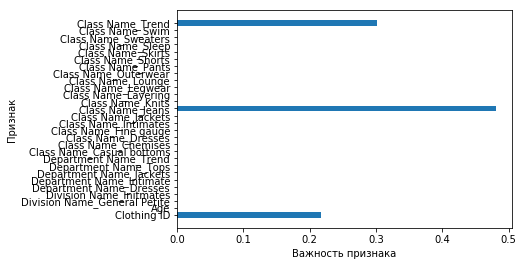

In [16]:
n_features = len(etalon_tree.feature_importances_)
plt.barh(range(n_features), etalon_tree.feature_importances_, align='center')
plt.yticks(range(n_features), X.keys())
plt.xlabel("Важность признака")
plt.ylabel("Признак")

#### Три самых важных признака

In [17]:
feature_dict = dict(zip(etalon_tree.feature_importances_ ,X.head()))
sorted_feature = sorted(etalon_tree.feature_importances_, reverse=True)
ss = ''
for score in  sorted_feature[:3]:
    ss+= feature_dict[score] + ' : ' + score.__str__() + ' '
ss

'Class Name_Jeans : 0.4809054343090333 Class Name_Trend : 0.3022333883685062 Clothing ID : 0.21686117732246055 '

### Использование случайного леса

In [18]:
forest = ens.RandomForestClassifier(n_estimators=120, n_jobs=-1, random_state=17)
forest.fit(X_train, y_train)
scores(y_holdout, forest.predict(X_holdout))

F - мера 0.8675843985578499
Полнота 0.9129160200034488
Точность 0.8265417642466822
Доля верных ответов 0.7706500141924496


#### Поиск гипепараметров

In [19]:
forest_params = {
        'n_estimators': range(100, 120),
        'random_state': range(87, 90),
        'max_features': range(1, 28),
    }
forest_grid = model_selection.GridSearchCV(
        ens.RandomForestClassifier(), forest_params, cv=5, n_jobs=-1, verbose=True)
forest_grid.fit(X_train, y_train)

Fitting 5 folds for each of 1620 candidates, totalling 8100 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   39.0s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  2.8min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  6.4min
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed: 11.7min
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed: 18.7min
[Parallel(n_jobs=-1)]: Done 1792 tasks      | elapsed: 27.8min
[Parallel(n_jobs=-1)]: Done 2442 tasks      | elapsed: 39.2min
[Parallel(n_jobs=-1)]: Done 3192 tasks      | elapsed: 54.1min
[Parallel(n_jobs=-1)]: Done 4042 tasks      | elapsed: 72.5min
[Parallel(n_jobs=-1)]: Done 4992 tasks      | elapsed: 95.7min
[Parallel(n_jobs=-1)]: Done 6042 tasks      | elapsed: 124.6min
[Parallel(n_jobs=-1)]: Done 7192 tasks      | elapsed: 160.5min
[Parallel(n_jobs=-1)]: Done 8100 out of 8100 | elapsed: 191.8min finished


GridSearchCV(cv=5, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'n_estimators': range(100, 120), 'random_state': range(87, 90), 'max_features': range(1, 28)},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=True)

In [20]:
forest_grid.best_params_ 

{'max_features': 17, 'n_estimators': 108, 'random_state': 89}

In [21]:
forest_grid.best_score_

0.770742092457421

In [22]:
etalon_forest = ens.RandomForestClassifier(n_estimators=forest_grid.best_params_['n_estimators'],
                                           n_jobs=-1, 
                                           random_state=forest_grid.best_params_['random_state'],
                                          max_features=forest_grid.best_params_['max_features'])
etalon_forest.fit(X_train, y_train)
scores(y_holdout, etalon_forest.predict(X_holdout))

F - мера 0.8674580433892756
Полнота 0.9136057941024315
Точность 0.8257481296758105
Доля верных ответов 0.7702242407039455


In [26]:
clrs = [etalon_knn, etalon_tree, etalon_forest]
res = {'Название метода': ['KNN', 'Решающее дерево', 'Случайный лес'],
    'Доля верных ответов':[metrics.accuracy_score(y_holdout, cl.predict(X_holdout)) for cl in clrs],
      'Точность':[metrics.precision_score(y_holdout, cl.predict(X_holdout)) for cl in clrs],
      'Полнота':[metrics.recall_score(y_holdout, cl.predict(X_holdout)) for cl in clrs],
      'F - мера':[metrics.f1_score(y_holdout, cl.predict(X_holdout)) for cl in clrs],
      'Площадь под ROC-кривой':[metrics.roc_auc_score(y_holdout, cl.predict(X_holdout)) for cl in clrs]}
result_table = pandas.DataFrame(data=res)
result_table
    

,Название метода,Доля верных ответов,Точность,Полнота,F - мера,Площадь под ROC-кривой
0,KNN,0.822594,0.823037,0.999310,0.902648,0.500056
1,Решающее дерево,0.823020,0.823020,1.000000,0.902919,0.500000
2,Случайный лес,0.770224,0.825748,0.913606,0.867458,0.508527


In [50]:
result_table['Название метода'][result_table['Доля верных ответов'].max() == result_table['Доля верных ответов']]

1    Решающее дерево
Name: Название метода, dtype: object

In [51]:
result_table['Название метода'][result_table['Площадь под ROC-кривой'].max() == result_table['Площадь под ROC-кривой']]

2    Случайный лес
Name: Название метода, dtype: object

In [52]:
result_table['Название метода'][result_table['Точность'].max() == result_table['Точность']]

2    Случайный лес
Name: Название метода, dtype: object

In [53]:
result_table['Название метода'][result_table['Полнота'].max() == result_table['Полнота']]

1    Решающее дерево
Name: Название метода, dtype: object

In [54]:
result_table['Название метода'][result_table['F - мера'].max() == result_table['F - мера']]

1    Решающее дерево
Name: Название метода, dtype: object